In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy as sci

#Creates function to remove extra spaces in sim file
def cleanlines(line):
    remove = ['  ', ' ']
    for r in remove:
        clean = line.replace(r, '') 
    split = clean.split(';')
    return split



In [2]:
#Creates empty array for x, y, and z value of hits
darrell_arr = np.dtype({"names": ['x_value', 'y_value','z_value', 'Material', 'Dep Energy [kev]'], "formats": [np.float32, np.float32, np.float32, 'S10', np.float32]})
xlist = []
ylist = []
zlist = []
matlist = []
e_list = []


In [3]:
data = open('FullConcreteModel.inc2.id1.sim', 'r')

In [4]:
def findmaterialandE(line):
    for i in range(1, len(line)):
        try:
            if line[-i] == '.':
                continue
            int(line[-i])
            
        except ValueError:
            energy = line[-(i-1):]
            material = line[2:i-1]
            return energy, material

1234.42077 Concrete


In [5]:
#Opens sim file

counter = 1
#Starts tallies in detector at 0
c = 0
hold_lines = []
found = False 
for l in data:
    
    line = cleanlines(l.strip('\n'))
    
    if len(line) >= 1 and line[0][0:2] == 'PM':
        found = True
        
        hold_lines.append(line)
        continue
    if found == True:
        hold_lines.append(line)
        
        if len(line) >= 1 and line[0][0:2] == 'PM':
            hold_lines = []
            found = False
            continue
        if len(line) > 1 and line[0][2:6] == 'BLAK':
            c+=1
#             print('H0=====>>', hold_lines[0][0])
            E, mat = findmaterialandE(hold_lines[0][0])
            #Tallies coordinates of hits
            matlist.append(np.str(mat))
            e_list.append(np.float32(E))
            xlist.append(np.float32(line[4]))
            ylist.append(np.float32(line[5]))
            zlist.append(np.float32(line[6]))
            
            found = False
            hold_lines = []
            
    #if counter > 10000:
       # break
data.close()

In [6]:
print(c)

useful_arr = np.zeros(len(xlist), darrell_arr)
useful_arr['x_value'] = xlist
useful_arr['y_value'] = ylist
useful_arr['z_value'] = zlist
useful_arr['Dep Energy [kev]'] = e_list
useful_arr['Material'] = matlist
useful_arr[5]

1569480


(736.2063, -143.17912, 333.73544, b'Asphalt1', 1332.492)

In [8]:
#Generates phi -180 to 180 degrees
phi = np.arctan2(useful_arr['y_value'],useful_arr['x_value'])*180/np.pi
phi[:10]

array([   1.6698331,  -32.545418 ,   54.11895  ,    1.3835136,
       -162.30359  ,  -11.005633 ,  156.02313  ,  106.37013  ,
        172.71367  ,  -87.5171   ], dtype=float32)

In [9]:
#Coverts phi degrees into cm
x = phi*np.pi*750/180
x[:10]

array([   21.858065,  -426.01852 ,   708.4154  ,    18.11015 ,
       -2124.549   ,  -144.06342 ,  2042.338   ,  1392.3817  ,
        2260.8167  , -1145.5962  ], dtype=float32)

In [10]:
#Confirms constant r of 750 cm
r = np.sqrt(useful_arr['x_value']**2+useful_arr['y_value']**2)
r[:10]

array([750.     , 750.     , 750.     , 750.00006, 749.99994, 749.99994,
       750.     , 750.     , 749.99994, 750.     ], dtype=float32)

In [11]:
z = useful_arr['z_value']
z[:10]

array([155.00739, 183.40178, 186.42738,  56.0451 , 255.60233, 333.73544,
       429.9304 , 813.096  , 214.63544, 443.00006], dtype=float32)

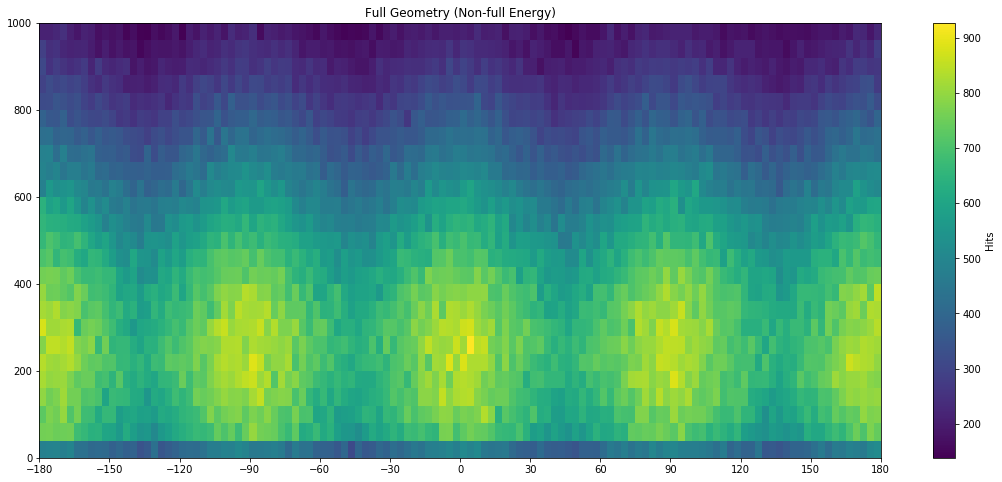

In [15]:
xedges = np.arange(-180.0, 180.1, 3.)
yedges = np.arange(0., 1000.1, 40.)
heatmap, _, __ = np.histogram2d(phi,useful_arr['z_value'], bins=[xedges, yedges])
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]

plt.clf()
plt.figure(figsize=(18.8496,8))
plt.imshow(heatmap.T, extent=extent, aspect='auto', origin='lower')
plt.xticks(np.arange(-180., 181., 30.))
# plt.xlim(100, 180)
cb = plt.colorbar(ticks=[100,200,300,400,500,600,700,800,900,1000])
cb.set_label('Hits')
plt.title('Full Geometry (Non-full Energy)')
plt.savefig('Full_Attenuated.png')
plt.show()

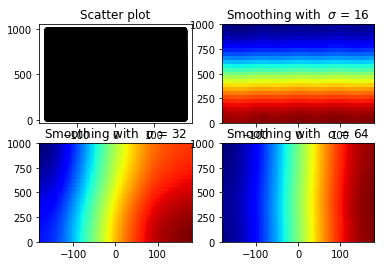

In [13]:
import matplotlib.cm as cm
from scipy.ndimage.filters import gaussian_filter


def myplot(phi,z, s, bins=[xedges, yedges]):
    heatmap, _, __ = np.histogram2d(phi,z, bins=[xedges, yedges])
    heatmap = gaussian_filter(heatmap, sigma=s)

    extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
    return heatmap.T, extent


fig, axs = plt.subplots(2, 2)


sigmas = [0, 16, 32, 64]

for ax, s in zip(axs.flatten(), sigmas):
    if s == 0:
        ax.plot(phi,z, 'k.', markersize=5)
        ax.set_title("Scatter plot")
    else:
        img, extent = myplot(phi,z, s)
        ax.imshow(img, extent=extent, origin='lower',aspect='auto', cmap=cm.jet)
        ax.set_title("Smoothing with  $\sigma$ = %d" % s)

plt.show()
